# Non-referenced OMDR measurement analsysis 

Here is a script that is used to analyse probably all the ODMR data that was recorded before we introduced ODMR referencing some time in 2020. The script will pull in the ODMR data and the params file for a given data set. Plot the results a heat map so that the drift across the measurement can be observed. 
In addition the data set will be condensed down to a single mean line scan which will be plotted as a scatter graph and a double lorentz curve will be fitted to the data to better determine the resonant frequnecy of the NV$^-$ centres present.  

In [1]:
import numpy as np 
import scipy.optimize as opt
import matplotlib.pyplot as plot
import os
import pandas as pd 

In [2]:
def import_data(file_location): 
    '''Import the OMDR data file.'''
    
    data = np.loadtxt(file_location)
    
    return(data)

In [3]:
def import_params(parmas_file_location): 
    '''Import the OMDR data file.'''
    
    params_data = pd.read_table(parmas_file_location, names = ['Parameter name', 'Parameter value'])
    
    return(params_data)

In [4]:
def mean_data(full_data):
    '''Perform a mean of the ODMR data'''
    
    mean_data = np.mean(full_data, axis = 0)
    
    return(mean_data)

In [5]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [6]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

In [7]:
def plot_heat_map(freq, odmr_data, dwell_time):
    # plot the full ODMR data as a heatmap. 
    number_of_scans = len(odmr_data)
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    fig1, ax1 = plot.subplots()
    
    hm = ax1.pcolormesh(freq, Y, odmr_data, cmap = 'cubehelix')
    fig1.colorbar(hm, label = '\nFluorescence intensity (per ' + str(dwell_time) + 'ms)')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of frequency scans')
    
    return(fig1, ax1)

In [8]:
def lorentz_2(x, A1, X01, sig1, A2, X02, sig2, offset):#P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # P0[0] = Amplitude 1, P0[1] = Resonance 1, P0[2] = FWHM 1
    # P0[3] = Amplitude 2, P0[4] = Resonance 2, P0[5] = FWHM 2, 
    # P0[6] = Offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    y = first_peak + second_peak + offset
    return(y)

In [9]:
def dc_sensitivity(line_width, error_FWHM, contrast, intensity, lorentz_fitting, NV_number):
    '''A calculation for the sensitvity of the NV centre (ensemble) used for 
    DC magnetic field sensitivity. Calulated using the equatuin presented in: 
    https://iopscience.iop.org/article/10.1088/2399-1984/ab5f9b/pdf
    
    equation: 
    eta = h / (g*mu_B) * line_width / (sqrt(I0) * Contrast)'''
    
    g_NV = 2.002 # Lande Factor
    mu_B = 9.27 # Bohr Magneton
    h = 6.626  # Planck Constant.
    
    power_h = -34 # power of plank constant
    power_mu_B = -24 # power of bohr magneton
    power_line_width = 9 # power of Giga Hertz
    
    total_power = power_h - power_mu_B # Total power for the 
    
    line_width = line_width * (10**power_line_width) # Convert to Hertz
    
    sqrt_intensity = np.sqrt(intensity * 100) # Convert to seconds
    
    eta_a = (h/(g_NV*mu_B)) # First fraction of the equation
    
    # Calculate the second fraction of the equation.
    eta_b_num = line_width 
    eta_b_denom = (sqrt_intensity * contrast * 100 *np.sqrt(NV_number))# convert to percentage
    
    eta_b = eta_b_num / eta_b_denom 
    
    # For trouble shooting, each phase of the sensitivity calculation has been broken into 
    # simple parts. 
    
    eta_c = eta_a * eta_b
    # Calculate sensitivity
    eta = eta_c*10**(total_power)    
    
    ### Calculating the error in sensitvity.
    
    delta_FWHM = error_FWHM # Error in FWHM
    delta_I0 = np.sqrt(intensity*100) # error in Off-resonant intensity (I0).
    delta_sqrt_I0 = 0.5 * 1/(intensity*100) # Error in sqrt(I0)

    # Error in fitted contrast measurment. 
    delta_contrast = contrast * np.sqrt( ( 1/np.sqrt( intensity*100 ) )**2 
                                           + ( 1/np.sqrt( np.min(lorentz_fitting) ) )**2 )

    # Fractional errors for the three variables recorded from measurement. 
    a = (delta_FWHM/FWHM)
    b = (delta_sqrt_I0/delta_I0)
    c = (delta_contrast/contrast)

    # Error in sensitivity. 
    delta_eta = eta * np.sqrt( a**2 + b**2 + c**2 )
    
    return(eta, delta_eta)

In [10]:
def save_data(date, file_ID, fitted_contrast, fit_param, error):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\Coplanar Waveguides\\' + date + '\\'
    output_data_file = destination_folder + date + '_reference_ODMR_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name'  + '\t' + 'Contast (%)' + '\t' +
                     + 'Res Freq 1 (GHz)' + '\t' + 'Err Res 1 (GHz)' + '\t' +
                     'Res Freq 2 (GHz)' + '\t' + 'Err Res 2 (GHz)' + '\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID  + '\t' + str(fitted_contrast*100) +  '\t' + 
                 str(fit_param[1]) + '\t' + str(error[1]) + '\t' +
                     str(fit_param[4]) + '\t' + str(error[4]) + '\n')

2.8602069005680355 2.873326262834467
0.00024716685386521914 0.0003544498608012043
0.10087729064501871
0.007983469259353485
2.9678667406593173e-08 5.354073205455198e-09


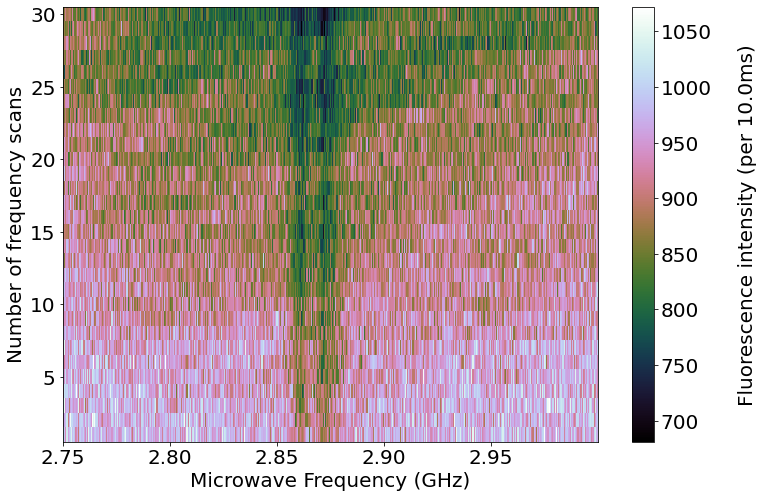

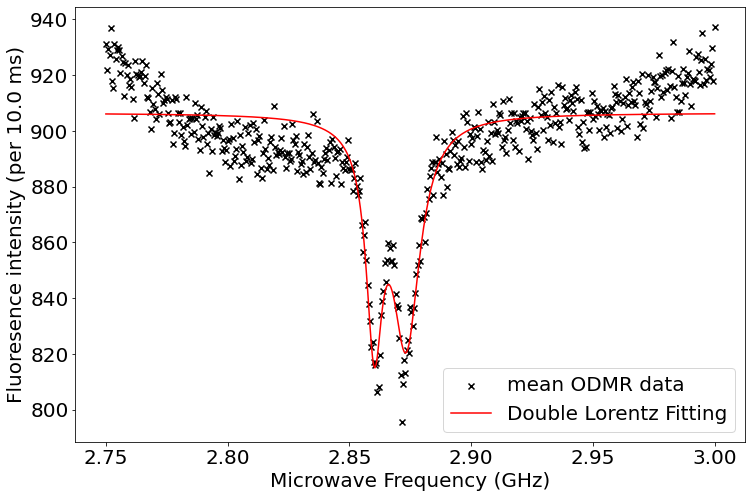

In [28]:
folder_loc = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\2019\\'
date = '20190827'
file_name = date + '_NVScan_01'

set_plot_params()

odmr_data = import_data(folder_loc + date + '\\' + file_name + '.dat')
params_data = import_params(folder_loc + date + '\\' + file_name + 'Params.dat')

freq = create_freq_scan(params_data['Parameter value'][0], params_data['Parameter value'][1], params_data['Parameter value'][2])

dwell_time = params_data['Parameter value'][3]

fig1, ax1 = plot_heat_map(freq, odmr_data, dwell_time)


mean_odmr_data = mean_data(odmr_data)

fig2, ax2 = plot.subplots()
plot.scatter(freq, mean_odmr_data, marker = 'x', color = 'k', 
            label = 'mean ODMR data')
#plot.axis([2.860, 2.880, 10600, 11600])
p0 = [-3000, 2.862, 0.005, -3000, 2.872, 0.005, 500]

#lower_bounds = [-np.inf, 2.850, -np.inf, -np.inf, 2.870, -np.inf, 0]
#upper_bounds = [np.inf, 2.865, np.inf, np.inf, 2.90,  np.inf, np.inf]

fit_params, confidence = opt.curve_fit(lorentz_2, freq, mean_odmr_data, p0, sigma = np.sqrt(mean_odmr_data))#, bounds = (lower_bounds, upper_bounds))
error = np.sqrt(np.diag(confidence))

y = lorentz_2(freq, fit_params[0], fit_params[1], fit_params[2], 
              fit_params[3], fit_params[4], fit_params[5], fit_params[6])

#y = lorentz_2(freq, p0[0], p0[1], p0[2], 
#              p0[3], p0[4], p0[5], p0[6])


plot.plot(freq, y, label = 'Double Lorentz Fitting', color = 'r') 
#plot.axis([ 2.7, 3.0, 55500, 56300])
plot.xlabel('Microwave Frequency (GHz)')
plot.ylabel('Fluoresence intensity (per ' + str(dwell_time) + ' ms)')
plot.legend()

fitted_contrast = 1-(np.min(y)/fit_params[6])


print(fit_params[1], fit_params[4])
print(error[1], error[4])
print(fitted_contrast)
#print(np.min(y), fit_params[6])

FWHM = float(np.sqrt([fit_params[2]**2 + fit_params[5]**2])/2)
print(FWHM)
error_FWHM = (np.sqrt(error[2]**2 + error[5]**2))
#print(error[2]**2 + error[5]**2)
#save_data(date, file_name, fitted_contrast, fit_params, error)
eta, delta_eta = dc_sensitivity(FWHM, error_FWHM, fitted_contrast, fit_params[6], y, 10)
print(eta, delta_eta)

#fig1.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\Coplanar Waveguides\\20190827\\' + file_name + 'ODMR_Heat_Map.pdf')
#fig2.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\Coplanar Waveguides\\20190827\\' +   file_name +'_ODMR_scatter_plot.pdf')

ValueError: x and y must be the same size

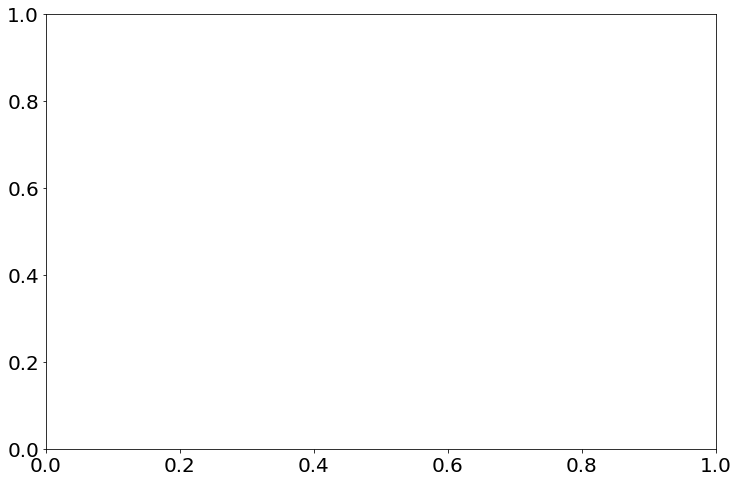

In [17]:
a = np.linspace(1, 1000, 1000)
b = np.mean(odmr_data, axis = 1)

plot.scatter(a, b)


In [19]:
def linear(x, m , c): 
    '''Linear fitting'''
    y = m*x + c
    return(y)

Text(0, 0.5, 'NV ensemble sensitivity (nT/$\\sqrt{Hz}$)')

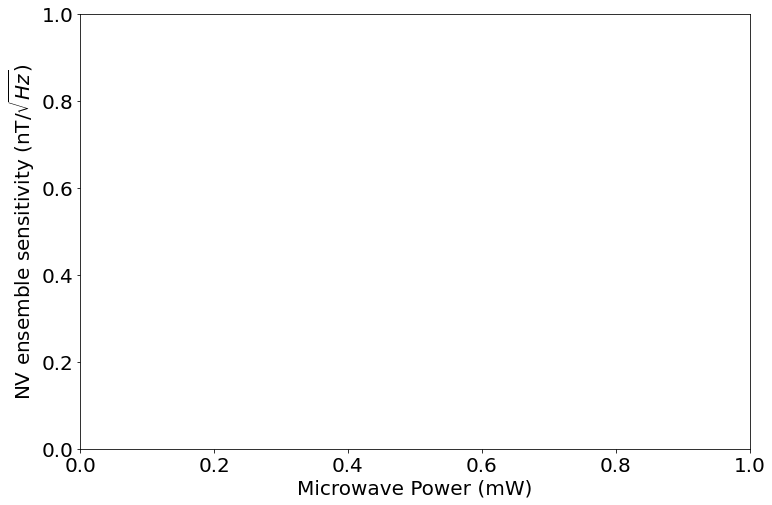

In [30]:
#FWHM = np.array(FWHM)*1000
#error_FWHM = np.array(error_FWHM)*1000
set_plot_params()
power = np.array([39, 36, 33, 30, 27, 24, 21, 18, 15, 12, 9, 6])
power_mW = 10**(power/10)
#print(np.array(FWHM).shape)
#print(power_mW)
#print(np.array(error_FWHM).shape)
p0 = [1,1]
#linear_fit, linear_error = opt.curve_fit(linear, np.sqrt(power_mW), FWHM,  p0, sigma = error_FWHM)
#y = linear(np.sqrt(power_mW), linear_fit[0], linear_fit[1])

#print(linear_fit)

#fig, ax = plot.subplots()
#plot.errorbar(np.sqrt(power_mW), FWHM, np.array(error_FWHM), color = 'k', marker = 'x',
#             linestyle = '', label = 'Mean FWHM measurement')
#plot.plot(np.sqrt(power_mW), y, color = 'k', label = 'Linear fit')
#plot.xlabel(r'$\sqrt{Microwave ~power}$' + r' (mW$^{\frac{1}{2}})$')
#plot.ylabel('FWHM (MHz)')
#plot.legend()
#fig.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\20210607\\FWHM_vs_sqrt_microwave_power.pdf')

#eta.append(dc_sensitivity(FWHM, fitted_contrast, fit_params[6]))

fig3, ax3 = plot.subplots()
#plot.semilogx(power_mW, np.array(eta)*10**9*(1/np.sqrt(500)), color = 'k', marker = 'x', 
 #            linestyle = '')
plot.xlabel('Microwave Power (mW)')
plot.ylabel(r'NV ensemble sensitivity (nT/$\sqrt{Hz}$)')


#plot.axis([3, 40, 0, 140])
#fig3.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\20210607\\Sensitivity_measurement.pdf')

In [46]:
def sin_wave(f, A, B, C,D):
    
    
    y =  A*np.sin(B*f+D)+C #+ m*f + C
    return(y)

In [ ]:
print(params_data)
#x = np.linspace(1, params_data['Parameter value'][4], int(params_data['Parameter value'][4]))
#plot.plot(x, np.mean(odmr_data, axis = 1))

In [35]:
mean_int_per_line = np.mean(odmr_data, axis = 1)
x = np.linspace(1, len(mean_int_per_line), len(mean_int_per_line))
p = [50, 1/5, 550, 90]

dwell_time = params_data['Parameter value'][3]/(10**6)
line_time = dwell_time * len(freq)

time = line_time * x

sin_fit, conf = opt.curve_fit(sin_wave, time, mean_int_per_line, p)

#y = sin_wave(time, sin_fit[0], sin_fit[1], sin_fit[2], sin_fit[3])
y = sin_wave(time, 50, 1/3.2, 550, 160)

fig3, ax3 = plot.subplots()
plot.scatter(time, mean_int_per_line, marker = 'x', color = 'k')
plot.plot(time,y)
plot.xlabel('Time (s)')
plot.ylabel('Mean Line-scan intensity (per 1ms)')


print(sin_fit)
#fig3.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\Coplanar Waveguides\\' + 'Oko-Labs_drift.pdf')

NameError: name 'sin_wave' is not defined

In [147]:
np.sqrt(3.1*10**6)*8

14085.453489327207

In [43]:
delta_FWHM = error_FWHM
delta_I0 = np.sqrt(fit_params[6]*100)
delta_sqrt_I0 = 0.5 * 1/(fit_params[6]*100)

delta_contrast = fitted_contrast * np.sqrt( ( 1/np.sqrt( fit_params[6]*100 ) )**2 
                                           + ( 1/np.sqrt( np.min(y) ) )**2 )

a = (delta_FWHM/FWHM)
b = (delta_sqrt_I0/delta_I0)
c = (delta_contrast/fitted_contrast)


delta_eta = eta[0] * np.sqrt( a**2 + b**2 + c**2 )

print(delta_eta)

3.693141085923897e-10


In [63]:
100/(6.636*558)

0.027005947789941257

In [64]:
2.7/8

0.3375

In [66]:
(4/3)*np.pi* (625*10**-9) * (250*10**-9)**2

1.6362461737446846e-19

In [67]:
(4/3)*np.pi* (90*10**-9)**3

3.0536280592892797e-21